In [1]:
import sys
import os
sys.path.append('../')
sys.path.append(r'C:\Users\tinc9\Documents\CNRS-offline')

import lpfet
import numpy as np
import matplotlib.pyplot as plt

import essentials
import seaborn as sns
import matplotlib.colors as mcolors

import importlib
importlib.reload(lpfet)

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

Did not import fast implementation. If you want fast implementation compile the pybind/pybind.cpp to pybind/Quant_NBody_accelerate.


# 6 site **chain** with constant potential difference between neighbouring atoms  
```
a-b-c-d-e-f
```
All depends on variable i - element of array x that sets potentials:


| site | external potential | 
| --- | --- |
| a | -2.5i | 
| b | -1.5i |
| c | -0.5i |
| d | +0.5i |
| e | +1.5i |
| f | +2.5i |

In [15]:
from importlib import reload
reload(lpfet)

<module 'lpfet' from 'C:\\Users\\tinc9\\Documents\\CNRS-offline\\quantum_main_project\\LPFET\\lpfet.py'>

In [19]:

def generate_chain_const_u(U_param, n_electron, n_sites, delta_x=0.1):
    lpfet.COMPENSATION_5_FACTOR = 1
    lpfet.COMPENSATION_5_FACTOR2 = 1
    lpfet.COMPENSATION_1_RATIO = 0.25

    x = np.arange(0, 2 + delta_x, delta_x)
    # delta_x = 0.1
    # U_param = 8
    # n_electron = 6
    # n_sites = 6
    name = 'chain1'
    folder_name = f'results/{name}_ns-{n_sites}_ne-{n_electron}_u-{U_param}_dist-{delta_x}/'
    for one_path in [folder_name, folder_name + 'v_hxc', folder_name + 'occupation']:
        if not os.path.isdir(one_path):
            os.mkdir(one_path)
    mol1 = lpfet.Molecule(n_sites, n_electron, name)
    mol_full = lpfet.class_Quant_NBody.QuantNBody(n_sites, n_electron)
    mol_full.build_operator_a_dagger_a()
    y = []
    v_hxc_progression_list = []
    y_simple = []
    y_ref = []
    energy_ref = []
    energy = []
    first = True
    correction_dict_list = []
    for i in x:
        if not first:
            mol1.clear_object(name)
        first = False
        print(f'{i:.1f}, {i / max(x) * 100:.1f}%: ', end=' ')

        nodes_dict = dict()
        edges_dict = dict()
        eq_list = []
        for j in range(6):
            nodes_dict[j] = {'v': (j - 2.5) * i, 'U': U_param}
            if j != 5:
                edges_dict[(j, j + 1)] = 1
            eq_list.append([j])
        t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
        mol1.report_string = f'Object with {n_sites} sites and {n_electron} electrons\n'
        mol1.add_parameters(u, t, v_ext, eq_list)
        mol1.self_consistent_loop(num_iter=50, tolerance=1E-6, oscillation_compensation=[5, 1],
                                  overwrite_output=folder_name + 'log.txt')
        # mol1.optimize_solution(5, 0.2)
        mol1.calculate_energy(True)
        correction_dict_list.append(mol1.oscillation_correction_dict)
        y.append(mol1.density_progress)
        y_simple.append(mol1.n_ks)
        y_ab, mol_fci, energy_ref_i = mol1.compare_densities_FCI(pass_object=mol_full)
        y_ref.append(y_ab.diagonal())
        v_hxc_progression_list.append(mol1.v_hxc_progress)
        energy.append(mol1.energy_contributions)
        energy_ref.append(energy_ref_i)

    calculate_graphs(folder_name, x, y, y_ref, y_simple, energy, energy_ref, v_hxc_progression_list, correction_dict_list)


def generate_chain_const_i(i_param, n_electron, n_sites, delta_x=0.5):
    lpfet.COMPENSATION_5_FACTOR = 5
    lpfet.COMPENSATION_5_FACTOR2 = 1
    lpfet.COMPENSATION_1_RATIO = 0.25

    x = np.arange(0, 10 + delta_x, delta_x)
    # delta_x = 0.1
    # U_param = 8
    # n_electron = 6
    # n_sites = 6
    name = 'chain1'
    folder_name = f'results/const-i_{name}_ns-{n_sites}_ne-{n_electron}_i-{i_param}_dist-{delta_x}/'
    for one_path in [folder_name, folder_name + 'v_hxc', folder_name + 'occupation']:
        if not os.path.isdir(one_path):
            os.mkdir(one_path)
    mol1 = lpfet.Molecule(n_sites, n_electron, name)
    mol_full = lpfet.class_Quant_NBody.QuantNBody(n_sites, n_electron)
    mol_full.build_operator_a_dagger_a()
    y = []
    v_hxc_progression_list = []
    y_simple = []
    y_ref = []
    energy_ref = []
    energy = []
    first = True
    correction_dict_list = []
    temp_v_hxc = []
    for i in x:

        if not first:
            mol1.clear_object(name)
            mol1.v_hxc = temp_v_hxc
        first = False
        print(f'{i:.1f}, {i / max(x) * 100:.1f}%: ', end=' ')
        print(mol1.v_hxc)
        nodes_dict = dict()
        edges_dict = dict()
        eq_list = []
        for j in range(6):
            nodes_dict[j] = {'v': (j - 2.5) * i_param, 'U': i}
            
            if j != 5:
                edges_dict[(j, j + 1)] = 1
            eq_list.append([j])
        print(nodes_dict)
        t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
        mol1.report_string = f'Object with {n_sites} sites and {n_electron} electrons\n'
        mol1.add_parameters(u, t, v_ext, eq_list)
        mol1.self_consistent_loop(num_iter=50, tolerance=1E-6, oscillation_compensation=[5, 1],
                                  overwrite_output=folder_name + 'log.txt')
        # mol1.optimize_solution(5, 0.2)
        mol1.calculate_energy(True)
        temp_v_hxc = mol1.v_hxc.copy()
        correction_dict_list.append(mol1.oscillation_correction_dict)
        y.append(mol1.density_progress)
        y_simple.append(mol1.n_ks)
        y_ab, mol_fci, energy_ref_i = mol1.compare_densities_FCI(pass_object=mol_full)
        y_ref.append(y_ab.diagonal())
        v_hxc_progression_list.append(mol1.v_hxc_progress)
        energy.append(mol1.energy_contributions)
        energy_ref.append(energy_ref_i)

    calculate_graphs(folder_name, x, y, y_ref, y_simple, energy, energy_ref, v_hxc_progression_list, correction_dict_list, x_label='U')


def calculate_graphs(folder_name, x, y, y_ref, y_simple, energy, energy_ref, v_hxc_progression_list, correction_dict_list,
                     x_label='i (v_ext)'):
    for i in range(len(y)):
        y[i] = np.array(y[i], dtype=float)
    y_ref = np.array(y_ref)
    y_simple = np.array(y_simple)

    E = np.array(energy, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])
    E_ref = np.array(energy_ref, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])

    # saving variables
    np.savetxt(folder_name + 'x.dat', x)
    np.savetxt(folder_name + 'y_ref.dat', y_ref)
    np.savetxt(folder_name + 'y_simple.dat', y_simple)
    with open(folder_name + 'y.dat', 'w', encoding='UTF-8') as conn:
        conn.write(repr(y))
    with open(folder_name + 'v_hxc_progression_list.dat', 'w', encoding='UTF-8') as conn:
        conn.write(repr(v_hxc_progression_list))
    np.savetxt(folder_name + 'E.dat', E)
    np.savetxt(folder_name + 'E_ref.dat', E_ref)

    # plot v_hxc progression
    for x_i, v_ext in enumerate(x):
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        regime = np.array(v_hxc_progression_list[x_i])
        for site_id in range(6):
            plt.plot(np.arange(len(regime)) + 1, regime[:, site_id], color=mpl.cm.tab10(site_id),
                     label=f'site{site_id}')

        plt.xlabel("Iteration number")
        plt.ylabel("v_hxc")
        plt.title(f'v_xhc progression at regime with {x_label}={v_ext:.3f}')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(f'{folder_name}/v_hxc/progression-{x_i}.png', dpi=150, bbox_inches='tight')
        plt.close(fig)

    # plot occupation progression
    for x_i, v_ext in enumerate(x):
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        regime = np.array(y[x_i])
        for site_id in range(6):
            plt.plot(np.arange(len(regime)) + 1, regime[:, site_id], color=mpl.cm.tab10(site_id),
                     label=f'site{site_id}')

        for key1 in correction_dict_list[x_i].keys():
            iter_key, site_key = key1
            plt.scatter([iter_key + 1], [regime[iter_key, site_key]], c='r', s=20)

        plt.xlabel("Iteration number")
        plt.ylabel("occupation")
        plt.title(f'occupation progression at regime with {x_label}={v_ext:.3f}')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(f'{folder_name}/occupation/progression_{x_i}.png', dpi=150, bbox_inches='tight')
        plt.close(fig)

    # plot energy contributions
    fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex='all', gridspec_kw={'height_ratios': [3, 1]})
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, top=0.93)
    ax[0].grid(True, color='#E2E2E2')
    ax[1].grid(True, color='#E2E2E2')
    ax[0].plot(x, E['tot'], c=mpl.cm.get_cmap('tab10')(0), label='tot E')
    ax[0].plot(x, E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0), linestyle='--')
    ax[0].plot(x, E['kin'], c=mpl.cm.get_cmap('tab10')(1), label='Kinetic contribution')
    ax[0].plot(x, E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1), linestyle='--')
    ax[0].plot(x, E['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
    ax[0].plot(x, E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), linestyle='--')
    ax[0].plot(x, E['v_ext'], c=mpl.cm.get_cmap('tab10')(3), label='Ext potential contribution')
    ax[0].plot(x, E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3), linestyle='--')
    plt.xlabel(x_label)
    ax[0].set_ylabel('energy')
    ax[1].set_ylabel('Error energy')
    ax[1].plot(x, E['tot'] - E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0))
    ax[1].plot(x, E['kin'] - E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1))
    ax[1].plot(x, E['u'] - E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
    ax[1].plot(x, E['v_ext'] - E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3))
    ax[1].plot(x, [0] * len(x), c='k', linestyle='--')
    # fig.suptitle(f'{n_sites} sites with U={U_param}, n_e = {n_electron}', fontsize=16)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f'{folder_name}/Energy_errors.png', dpi=300, bbox_inches='tight')

    # plot occupations
    colors = plt.cm.viridis(np.linspace(0, max(x), len(x)))
    norm = mpl.colors.Normalize(vmin=0, vmax=max(x))
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    for i in range(6):
        plt.plot(x, y_simple[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i))
        plt.plot(x, y_ref[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i) + '-ref', linestyle='--')
    plt.xlabel(x_label)
    plt.ylabel("occupation")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
               ncol=3, fancybox=True, shadow=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f'{folder_name}/Densities.png', dpi=150, bbox_inches='tight')



	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====
0.0, 0.0%:  [0. 0. 0. 0. 0. 0.]
{0: {'v': -2.5, 'U': 0.0}, 1: {'v': -1.5, 'U': 0.0}, 2: {'v': -0.5, 'U': 0.0}, 3: {'v': 0.5, 'U': 0.0}, 4: {'v': 1.5, 'U': 0.0}, 5: {'v': 2.5, 'U': 0.0}}
((0): 0.00 0.00 0.00), ((1): 0.00 0.00 0.00), ((2): 0.00 0.00 0.00), ((3): 0.00 0.00 0.00), ((4): 0.00 0.00 0.00), ((5): 0.00 0.00 0.00), Loop 0, ((0): 0.00 0.00 0.00), ((1): 0.00 0.00 0.00), ((2): 0.00 0.00 0.00), ((3): 0.00 0.00 0.00), ((4): 0.00 0.00 0.00), ((5): 0.00 0.00 0.00), Loop 1, FCI densities (per spin): [0.98595345 0.86429332 0.52535339 0.47464661 0.13570668 0.01404655]
Eigenvalue energy: -10.9836288256108, calculated from contributions: -10.9836288256108
0.5, 5.0%:  [0. 0. 0. 0. 0. 0.]
{0: {'v': -2.5, 'U': 0.5}, 1: {'v': -1.5, 'U': 0.5}, 2: {'v': -0.5, 'U': 0.5}, 3: {'v': 0.5, 'U': 0.5}, 4: {'v': 1.5, 'U': 0.5}, 5: {'v': 2.5, 'U': 0.5}}
((0): 0.00 0.42 0.45), ((1): 0.00 0.41 0.44), ((2): 0.00 0.26

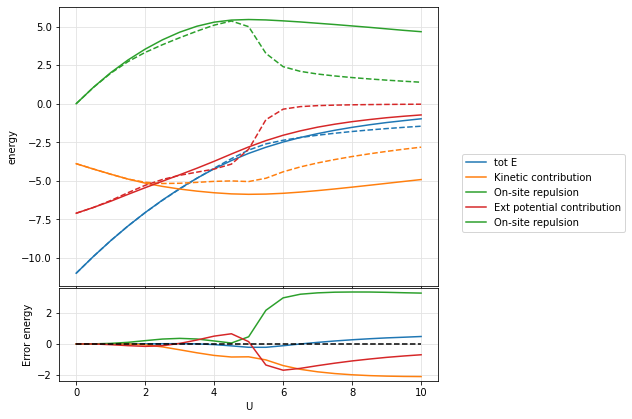

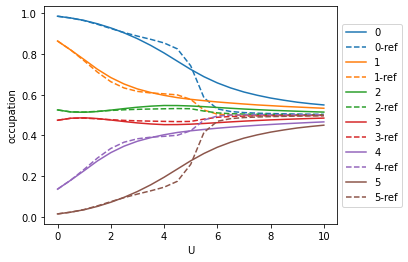

In [20]:
generate_chain_const_i(1, 6, 6)


	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====
0.0, 0.0%:  ((0): 0.00 1.00 3.90), ((1): 0.00 1.00 3.61), ((2): 0.00 1.00 3.26), ((3): 0.00 1.00 3.26), ((4): 0.00 1.00 3.61), ((5): 0.00 1.00 3.90), Loop 0, ((0): 1.00 0.99 2.90), ((1): 1.00 0.99 2.61), ((2): 1.00 0.98 2.26), ((3): 1.00 0.98 2.26), ((4): 1.00 0.99 2.61), ((5): 1.00 0.99 2.90), Loop 1, FCI densities (per spin): [0.91183538 0.79661523 0.79154938 0.79154938 0.79661523 0.91183538]
Eigenvalue energy: 12.767218610937869, calculated from contributions: 12.767218610937869
0.1, 5.0%:  ((0): 0.00 1.00 3.96), ((1): 0.00 1.00 3.82), ((2): 0.00 1.00 3.50), ((3): 0.00 1.00 3.13), ((4): 0.00 1.00 3.27), ((5): 0.00 1.00 3.80), Loop 0, ((0): 1.00 0.99 2.96), ((1): 1.00 0.99 2.82), ((2): 1.00 0.99 2.51), ((3): 1.00 0.97 2.14), ((4): 1.00 0.98 2.27), ((5): 1.00 0.99 2.80), Loop 1, FCI densities (per spin): [0.94704217 0.84111337 0.79333187 0.78888664 0.76226047 0.86736549]
Eigenvalue energy: 12

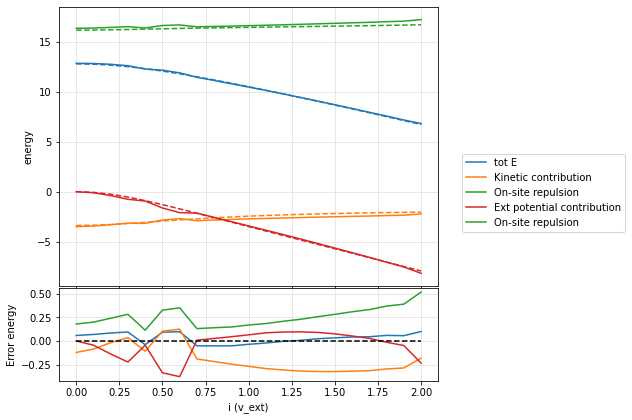

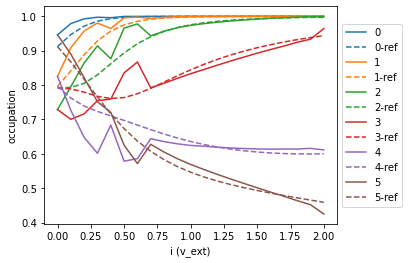

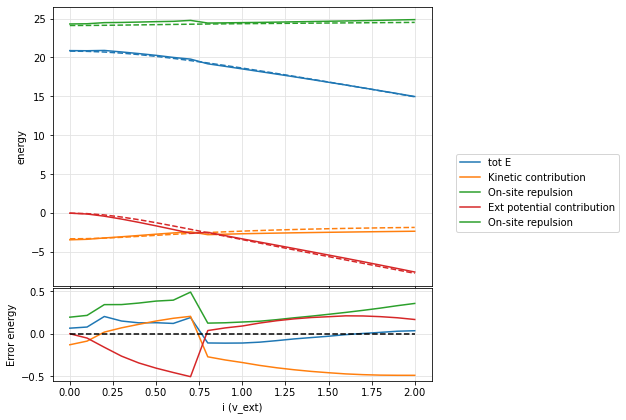

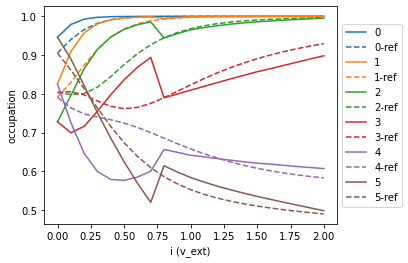

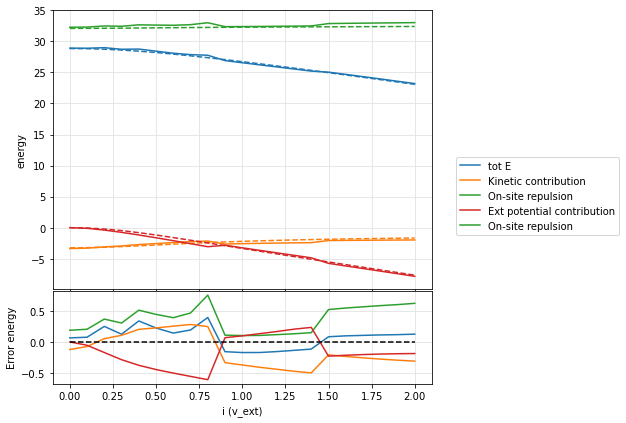

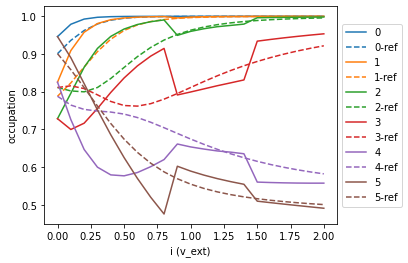

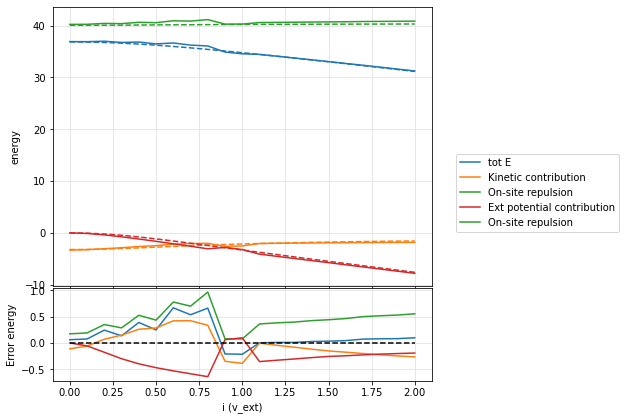

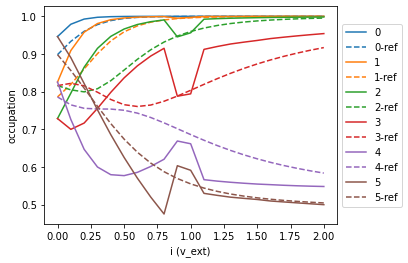

In [5]:
for electrons in [2, 4, 6, 8, 10]:
    for param_u in [2, 4, 6, 8, 10]:
        generate_chain_const_u(param_u, electrons, 6)